In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

/Users/kuldeepchinwan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_csv('memory_selnav.csv')

In [3]:
df.columns

Index(['metricType', 'host', 'value', 'timestamp'], dtype='object')

In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(by=['host','timestamp'])

In [8]:
df_host = df.drop_duplicates()

In [9]:
# --- Step 4: fill missing timestamps per host ---
cleaned = []
for host, g in df_host.groupby('host'):
    g = g.set_index('timestamp')
    # full 1-min range for this host
    full_index = pd.date_range(start=g.index.min(), end=g.index.max(), freq='1min')
    g = g.reindex(full_index)
    g['host'] = host
    # interpolate small gaps
    g['value'] = g['value'].interpolate(limit=3)
    cleaned.append(g.reset_index().rename(columns={'index':'timestamp'}))

df_host = pd.concat(cleaned, ignore_index=True)

In [10]:
# --- Step 5: drop duplicates ---
df_host = df_host.drop_duplicates(subset=['host','timestamp'])

In [11]:
# --- Step 6: fix impossible values ---
df_host['value'] = df_host['value'].clip(lower=0)
upper = df_host['value'].quantile(0.999)  # cap extreme spikes
df_host['value'] = df_host['value'].clip(upper=upper)

In [12]:
# --- Step 7: optional normalization per host ---
df_host['value_norm'] = 0.0
for host, g in df_host.groupby('host'):
    scaler = StandardScaler()
    normed = scaler.fit_transform(g[['value']])
    df_host.loc[df_host['host']==host, 'value_norm'] = normed

In [13]:
df_host.describe()

,timestamp,value,value_norm
count,10019,9787.000000,9.787000e+03
mean,2025-08-27 06:00:00,91.004635,4.732402e-14
min,2025-08-23 18:31:00,90.549000,-2.299262e+00
25%,2025-08-25 12:15:30,90.830000,-8.812571e-01
50%,2025-08-27 06:00:00,91.036000,1.582768e-01
75%,2025-08-28 23:44:30,91.160000,7.840156e-01
max,2025-08-30 17:29:00,91.428214,2.137499e+00
std,NaN,0.198176,1.000051e+00


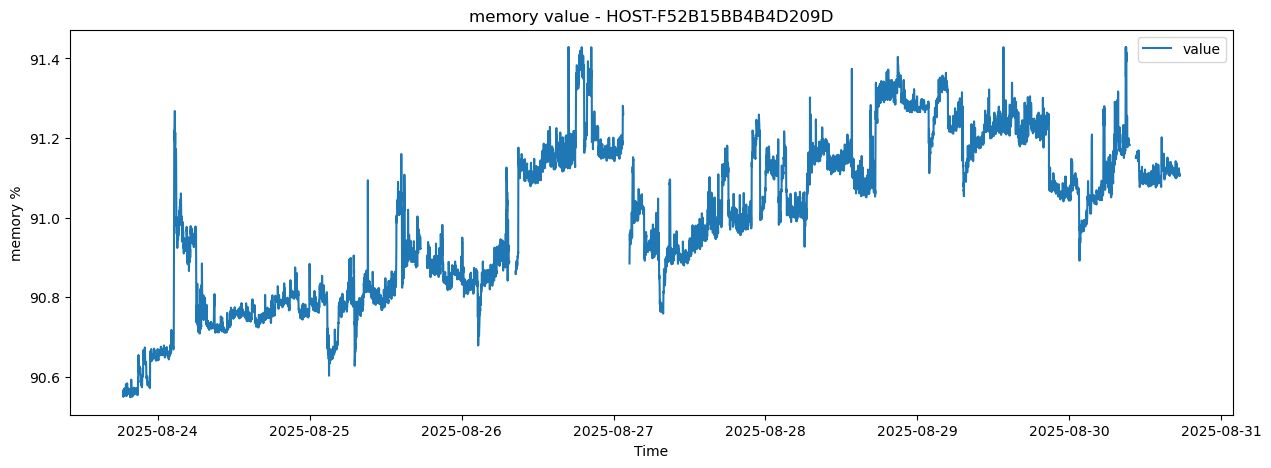

In [14]:
# Plot one host for full week
host_id = df_host['host'].unique()[0]
subset = df_host[df_host['host']==host_id]

plt.figure(figsize=(15,5))
plt.plot(subset['timestamp'], subset['value'], label='value')
plt.title(f"memory value - {host_id}")
plt.xlabel("Time")
plt.ylabel("memory %")
plt.legend()
plt.show()

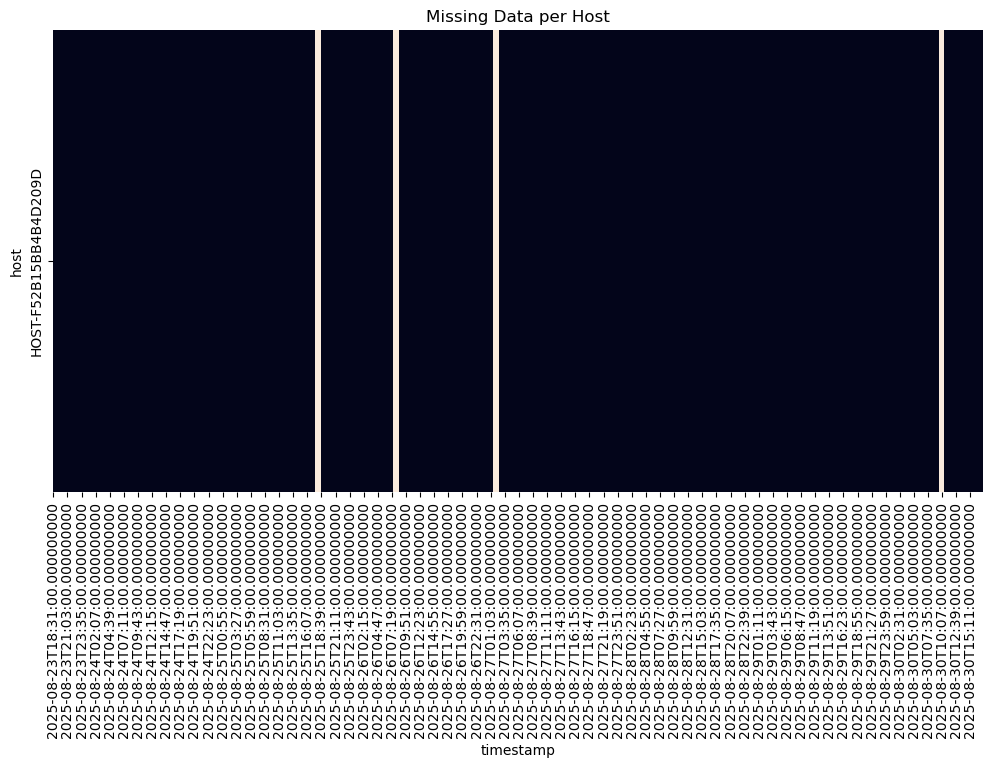

In [15]:
pivot = df_host.pivot(index='timestamp', columns='host', values='value')
plt.figure(figsize=(12,6))
sns.heatmap(pivot.isna().T, cbar=False)
plt.title("Missing Data per Host")
plt.show()

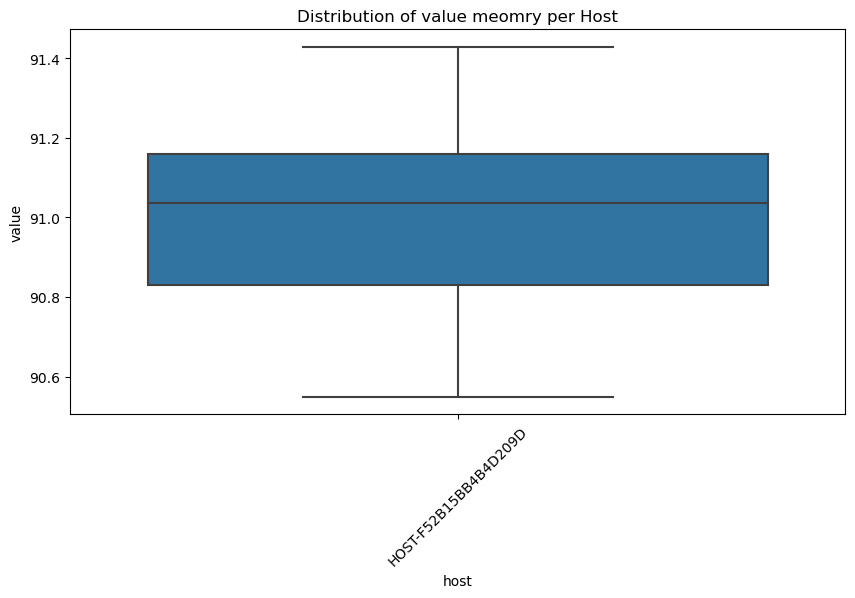

/Users/kuldeepchinwan/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


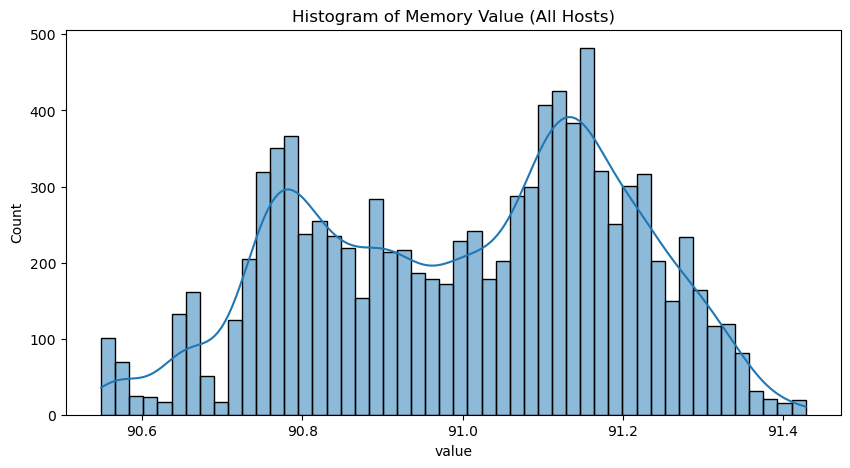

In [16]:
plt.figure(figsize=(10,5))
sns.boxplot(x='host', y='value', data=df_host)
plt.title("Distribution of value meomry per Host")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,5))
sns.histplot(df_host['value'], bins=50, kde=True)
plt.title("Histogram of Memory Value (All Hosts)")
plt.show()

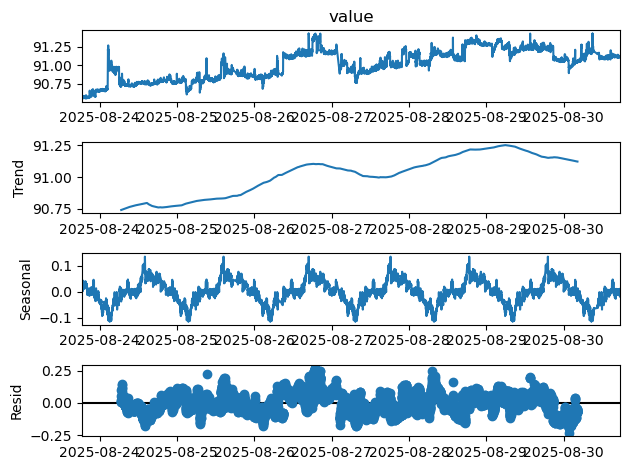

In [17]:
subset = subset.set_index('timestamp').asfreq('1min')
subset = subset.dropna()
result = seasonal_decompose(subset['value'], model='additive', period=1440)  # 1440 min = 1 day
result.plot()
plt.show()

In [18]:
df_host.to_csv('processed_memory_db.csv')